# Tutorial 4: Quantitative Image Processing  

© 2017 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)  

In [1]:
# Our standard modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities for image processing
import skimage.io
import skimage.exposure
import skimage.measure

sns.set(style="darkgrid") # Gray background and white grid
sns.set_context('talk') # Sets a default size for curves and fonts

# To allow for inline rendering of plots.
%matplotlib inline

In this tutorial, we will learn how to load, manipulate, and extract quantitative data from microscopy images. The data set used in this experiment can be downloaded from [here](http://www.rpgroup.caltech.edu/courses/bi1_2017/data/ecoli_images.zip). 

## Viva la revolución

Much like sequencing has revolutionized how we think of the origin and diversification of life, microscopy has revolutionized how we think about cellular function. Over the past decade and a half, we have pushed our ability to image past the diffraction limit of light, cracking open a world teeming with scientific questions we couldn't have come up with otherwise. 

Of course, microscopy is not a "new" method like DNA sequencing. In the late seventeenth century, Antonie van Leeuwenhoek developed the first microscope. While the ball-lens design allowed for only a small region of focus at a modest magnification, he was able to see the myriad life forms around him that hid from observation by the naked eye. While I will leave the details to your imagination, he looked at a large array of body fluids and samples from his surroudings. He was not able to capture the images he saw but he paid close attention and sketched his observations. The image below shows the design of his microscope (left) and some of his sketches (right). 

![](../images/leewunhoek_microscope.jpg)

The current top-of-the-line microscopes permit observation of life at impressively high resolution and speed. The [lattice light-sheet microscope](http://science.sciencemag.org/content/346/6208/1257998/tab-pdf) is arguably the most advanced microscope in use today. Through some clever tricks of illumination, this microscope allows us to make single-molecule measurements in living cells in real time. Please see these videos on [cell division](https://www.youtube.com/watch?v=y2QXXdw2B4U), [cell movement through collagen networks](https://www.youtube.com/watch?v=UmxKxpKua2M), and [cell-cell interaction](https://www.youtube.com/watch?v=sKN8rRZhym0) for examples of images captured on a lattice light sheet micrsocope. This microscope is certainly more complicated than van Leeuwenhoek's first design (image below, left side), but the resulting images are truly astounding (image below, right side).

![](../images/lattice_lightsheet.png)

The development of the electron microscope was another thrust forward in our ability to resolve the stuff of life. Although this method cannot make measurements of *living* cells, it can resolve the details of life down to the atomic level. In addition to [tomographic imaging](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2869529/pdf/cshperspect-PRK-a003442.pdf), electron microscopy can be used to resolve the structure of large proteins and protein complexes down to a few angstroms of resolution. For some beautiful examples of electron microscopy images, take a look at the lab of Caltech's own [Grant Jensen](http://jensenlab.caltech.edu/movies/).

With this technical revolution comes a problem $-$ we are drowning in data. It's now relatively easy to generate 1 TB of image data in a single experiment. This means there is now a bottleneck in our ability to properly analyze and extract the quantitative information buried within the images. In the coming sections, we will cover how one can make such measurements. The images themselves are not exceedingly complex, however this tutorial will hopefully demonstrate how one can analyze images with the same rigor and purpose as any other type of quantitative data.

##  What are we after?

In class (and in homework 6), we showed how we can use some priciples of statistical mechanics to generate a model for the regulation of a gene by a repressor protein. We began by enumerating the states and weights of the promoter and when the dust settled, we were left with an equation describing the fold-change in gene expression, 

$$
\text{fold-change} = \left(1 + {R \over N_{NS}}e^{-\Delta\varepsilon_r / k_BT}\right)^{-1}, \tag{1}
$$

where $R$ is the number of repressor proteins per cell, $N_{NS}$ is the number of non-specific binding sites available to the repressor, $\Delta\varepsilon_r$ is the binding energy of the repressor to the DNA, and $k_BT$ is the thermal energy of the system (with $k_B$ as the Boltzmann constant and $T$ as the temperature). 

We are able to directly manipulate many of these "biophysical knobs". For example, we can change the repressor copy number by manipulating the ribosomal binding site of the repressor gene, making it stronger or weaker to produce many or few repressor proteins. We can also change the strength at which the repressor binds the DNA by manipulating the DNA sequence of the repressor binding site, known as the operator. While we can change these parameters (and determine their values through independent methods), we need to engineer some kind of reporter system that will allow us to actually measure the gene expression. The development of fluorescent proteins and epifluorescence microscopy has allowed us to make such measurements by observing just how brightly the bacterial cells glow. A schematic of our strains with the various biophysical knobs can be seen below. In this construct, we have directly placed these manipulated genes into the bacterial chromosome, indicated by the black circles.  

![](../images/titrationconstruct.png)


While we can make predictions about the behavior of these systems by plugging values into Equation 1, we would like to verify them by experimentally measuring the fold-change in gene expression. We recall that the fold-change is simply the ratio of the probability of an RNA polymerase molecule being bound to the promoter ($p_\text{bound}$) in the presence of repressor protein  to that in the absence of repressor,

$$
\text{fold-change} = {p_\text{bound}(R > 0) \over p_\text{bound} (R = 0)}. \tag{2}
$$

Since we have built some bacterial strains that express a fluorescent protein, we can experimentally measure the fold-change by taking the ratio of the brightness of a cell in the presence of repressor (dim) to that in the absence (bright), 

![](../images/fold_change_cartoon.jpg)


which can be written mathematically as, 

$$
\text{fold-change} = {\langle I_\text{R > 0} \rangle - \langle I_\text{background}\rangle \over \langle I_\text{R = 0}\rangle - \langle I_\text{background}\rangle}, \tag{3}
$$

where $\langle I_\text{R > 0} \rangle$ and $\langle I_\text{R = 0}\rangle$ is the average single cell intensity in the presence and absence of repressor, respectively and $\langle I_\text{background}\rangle$ is the average background fluorescence of the cell. While you may not expect it at first pass, cells are slightly fluorescent even when they are not expressing any fluorescent proteins. Since we are making the assumption that gene expression is proportional to the probability of a polymerase being bound to the promoter, we must correct for the baseline fluorescence (autofluorescence for short) of the cells.  

In the coming sections, you will learn how to read in images from your computer, identify the regions which are bacteria, and make some measurements of their intensity.  We will be working with some images of *E. coli* taken under a contrast generation method called [phase contrast](https://en.wikipedia.org/wiki/Phase-contrast_microscopy) for segmentation and a YFP illumination image for the fluorescence channel. This data set can be downloaded [here](http://www.rpgroup.caltech.edu/courses/bi1_2017/data/ecoli_images.zip).

## What is a digital image?

Digital images are nothing but a matrix in which each index is assigned a number reprenting the value at that point. These indices, more commonly called pixels, are a measure of how many photons hit that particular position on the camera sensor. Note that in the case of analog film, there are no such things as pixels and the information is contained in the pigmentation of a film negative. Virtually all images you will deal with in your scientific career (and probably your life in general) will be digital, so we will use the term "image" and "digitial image" interchangeably.


As images are nothing but matrices, we can do many of the same mathematical operations on images as we do on matrices. However, we don't want to manually generate every image by populating a matrix. This means that we will have to have some manner of interacting with image files on our computer programmatically. Although it is beyond the scope of this tutorial, you should be familiar [with the different file formats](https://en.wikipedia.org/wiki/Image_file_formats) of images and their benefits and drawbacks. For all scientific images, you should save them in a file format that minimizes the data lost due to compression. The most common file format you will run into is the Tagged Image File Format (`.tiff` or `.tif`) which is a lossless compression format. Unfortunately, you will sometimes run into images saved as `.jpg`. **Never save data you care about as jpegs!** This file format uses a lossy compression algorithm, meaning that you will be throwing away some of your data. 

## Loading images

There are several image processing libraries available in Python, such as [Sci-kit Image](http://scikit-image.org), [Scipy.ndimage](https://docs.scipy.org/doc/scipy-0.18.1/reference/ndimage.html), [Python Imaging Library](http://effbot.org/imagingbook/pil-index.htm), and [Open CV](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html). While each have their own features, they all have the same (or at least very similar) utilities. For our purposes, we will be using the Sci-kit Image library (hereafter referred to as `skimage`) as it has everything we need packaged together in some very easy to use functions.

The `skimage` module has a large number of submodules. Each submodule has an array of functions assoicated with one kind of image manipulation. For example, the `filters` submodule contains a variety of functions that will perform different filtering operations. The submodule `measure` is composed of functions useful for making measurements of segmented object. The submodule `io` allows for file input/output. While `skimage` is a very powerful module, we'll only use a small portion of its capability for the purposes of this tutorial.

To begin, let's read the image into memory using the `skimage.io.imread` function. 

In [3]:
# Load the phase contrast image by providing the file path
phase_im = skimage.io.imread('data/gene_expression/ecoli_phase_01.tif')

In this cell, we've assigned the loaded image to the variable `phase_im`. As we have mentioned before, **an image is nothing but a matrix of values.** We can prove this to ourselves by printing the values of the array. 

In [4]:
# Look at the phase_im array
phase_im

array([[6539, 6108, 5913, ..., 5921, 5903, 5787],
       [5875, 5875, 5875, ..., 5903, 5808, 5787],
       [5494, 5494, 5556, ..., 5903, 5817, 5817],
       ...,
       [5633, 5467, 5467, ..., 5579, 5347, 5347],
       [5467, 5292, 5292, ..., 5614, 5938, 6077],
       [5292, 5292, 5292, ..., 5614, 6077, 6077]], dtype=uint16)

We can see that our image is a very large matrix with some value at each entry (called a 'pixel'). At the end of this array, we can see that the data type (`dtype`) of this image is `uint16`. This means that the image is composed of unsigned integers (can only be 0 or positive) with a bit depth of 16. A 16-bit image allows for values ranging from 0 to $2^{16} - 1 = 65535$. The larger the bit depth, the more information your image will contain. For comparison, nearly all commercial cameras for photography (everything from your iPhone camera to a Nikon D5) have a bit depth of 8 for each channel in an RGB image. For qualitative consumption, an 8-bit image is sufficient as the human eye can only distinguish around 200 different hues. However, in science we are often more interested in making quantitative measurements from our images. For this reason, the majority of microscopy images are either 12, 14, or 16 bit images.

While an image is nothing but a matrix, it's not very useful for us just to look at the numbers printed out on our screen. Rather, we will plot the image, assigning each value a color. 

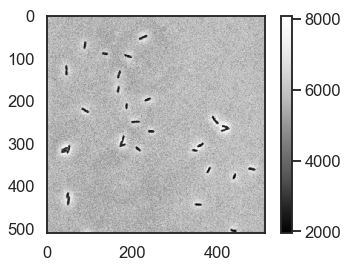

In [5]:
with sns.axes_style('white'):
    # Set the colormap for data display. 
    gray = plt.cm.Greys_r

    # Show the image
    plt.imshow(phase_im, cmap=gray)

    # Add a colorbar
    plt.colorbar()

In this image, we've used a gray colormap where the lowest pixel values are shown in black and the brightest in white. This colormap is perceptually flat, meaning that the transition from black to white is linear across all pixel values. It appears that all of the bacteria are dark, meaning that their pixel values are lower than the values of the background pixels.

<div class="alert alert-info">

<span style="font-size: 1em;">**A quick note on colormaps...**<br /><br ></span>


By a very large margin, the most commonly seen colormap in used in science is [Jet](https://people.nscl.msu.edu/~noji/files/ROOT/cm_matlab/jet.png). **This is a horrible colormap and should never be used**. This is not coming from my personal preference. This colormap is actually [incredibly misleading](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) as the transition between colors is not even. This leads to fringing which people often interperet as a boundary in their data. For this reason, MathWorks (the creators of MATLAB) and the creators of Matplotlib reformed their default colormaps to address this issue. Here is a very [interesting write-up of these changes](https://bids.github.io/colormap/) which includes a more in-depth discussion of what makes a good colormap.  
</div>

## Segmentation - Where are the cells? 

We can see in the above image that all of the bacteria are significantly darker compared to the background of the image. If we wanted to identify the regions of the image that correspond only to the bacteria, we could very easily draw a **threshold** at this value. We could then go through each individual pixel, determine whether its value is above or below this threshold, and mark it as either a bacterium (`1.0`) or background (`0.0`). 

But how do we determine this threshold? We *could* try guessing a bunch of different values and seeing which works or we could look at the histogram of the image. We can predict that the histogram would show two peaks $-$ one for the background pixels and one for the bacteria. We'll use the `skimage.exposure` submodule to generate the histogram of the image and plot it. The function `skimage.exposure.histogram` will return the frequency values and the bin centers rather than just generating the plot.

Text(0, 0.5, 'counts')

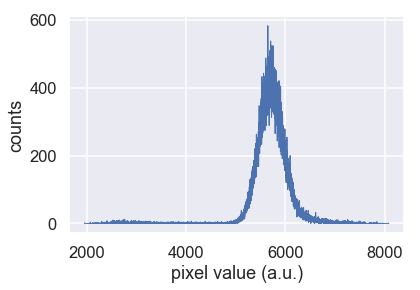

In [6]:
# Generate the histogram of the image. `skimage.exposure.histogram` will return
# the values of the histogram as well as the centers of the bins.
hist, bins = skimage.exposure.histogram(phase_im)

# Plot the histogram values versus the bin centers.
plt.plot(bins, hist, linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('counts')

We can see that the largest peak in the histogram peters off around a pixel count of 5000. Since our bacteria are dark, we can use this value as our threshold and mark anything below this value as belonging to bacteria. 

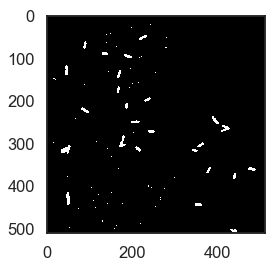

In [8]:
# Threshold the image showing pixels only below 5000 counts
thresh_val = 5000
thresh_im = phase_im < thresh_val

# Plot the image.
with sns.axes_style('white'):
    plt.imshow(thresh_im, cmap=gray)

That looks pretty good! While we do pick up some background pixels, we seem to  get all of the bacteria without an issue. Since we will want to apply this procedure to a large number of images, we should try this same approach on another image just to make sure that it's robust. 

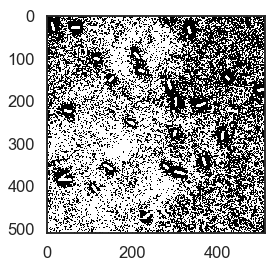

In [9]:
# Load another phase contrast image.
phase_im2 = skimage.io.imread('data/gene_expression/ecoli_phase_02.tif')
                              

# Apply the threshold value of 5000 counts. 
thresh_im2 = phase_im2 < thresh_val

# Show the image.
with sns.axes_style('white'):
    plt.imshow(thresh_im2, cmap=gray)

Yikes, that looks pretty horrible. It looks like with this threshold value, we segment the cells, but also a bunch of stuff in the background! It appears that there are differences in the distribution of pixel values between these two images. To check this, let's take a look at the histogram of each image overlaid with eachother.  

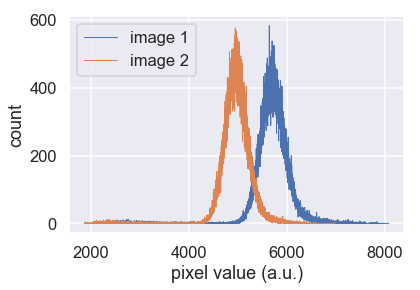

In [10]:
# Generate the histograms for each image.
hist_im1, bins_im1 = skimage.exposure.histogram(phase_im)
hist_im2, bins_im2 = skimage.exposure.histogram(phase_im2)

# Each histogram over eachother. 
plt.plot(bins_im1, hist_im1, label='image 1', linewidth=1)
plt.plot(bins_im2, hist_im2, label='image 2', linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('count')
plt.legend()

Those are certainly different! In fact, it appears that our threshold value of 5000 falls right about at the mode of the second image! To segment our cells, we will want to make sure that each image is set at the same scale. We can do this experimentally by taking the time to ensure that the illumination is exactly the same at each position, or we could do it in post processing. We can **normalize** the image such that all pixel values vary between 0.0 and 1.0. We can do so as

$$
I_\text{norm} = {I - I_\text{min} \over I_\text{max} - I_\text{min}} \tag{x}
$$

where $I$ is the original image, $I_\text{min}$ is the minimum value of the image, and $I_\text{max}$ is the maximum value. Let's write a function that will do this normalization for any image we provide. 

In [11]:
def normalize_im(im):
    """
    Normalizes a given image such that the values range between 0 and 1.     
    
    Parameters
    ---------- 
    im : 2d-array
        Image to be normalized.
        
    Returns
    -------
    im_norm: 2d-array
        Normalized image ranging from 0.0 to 1.0. Note that this is now
        a floating point image and not an unsigned integer array. 
    """
    im_norm = (im - im.min()) / (im.max() - im.min())
    return im_norm

Let's test it out on our images and look at both histograms.  

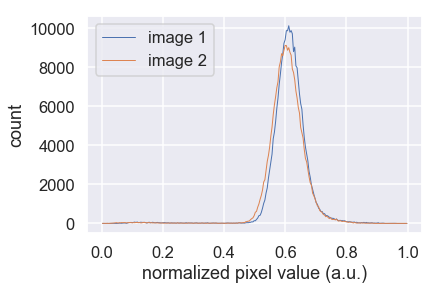

In [12]:
# Normalize both images.
phase_norm1 = normalize_im(phase_im)
phase_norm2 = normalize_im(phase_im2)

# Generate both histograms. 
hist_norm1, bins_norm1 = skimage.exposure.histogram(phase_norm1)
hist_norm2, bins_norm2 = skimage.exposure.histogram(phase_norm2)

# Plot both histograms on the same set of axes. 
plt.plot(bins_norm1, hist_norm1, label='image 1', linewidth=1)
plt.plot(bins_norm2, hist_norm2, label='image 2', linewidth=1)

# Add labels as expected. 
plt.xlabel('normalized pixel value (a.u.)')
plt.ylabel('count')
plt.legend()

That is much better! They are nearly identical. Note that the scale on our $x$-axis now ranges from 0.0 to 1.0. By performing this normalization, we now only care about how dark the bacteria are *relative* to the background rather than its absolute pixel value. By eyeballing it, we can say that a reasonable threshold value would be around 0.3, which avoids the small shift of the background intensity. Let's take a look at both segmentation masks along with the original images on a single set of axes. We can do this using a more complicated manner of plotting using subplots. These subplots will allow us to show two different images at the same time on the same sets of axes.

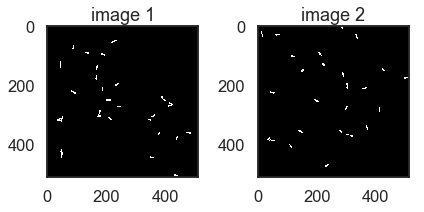

In [17]:
# Apply the threshold. 
thresh_val = 0.3
thresh_im1 = phase_norm1 < thresh_val
thresh_im2 = phase_norm2 < thresh_val

with sns.axes_style('white'):
    # Set up the axes for plotting.  
    fig, ax = plt.subplots(nrows=1, ncols=2)
    # This generates a single row of images with two columns
    # and assigns them to  a variable `ax`.

    # Plot the first image
    ax[0].imshow(thresh_im1, cmap=gray)
    ax[0].set_title('image 1')

    # Plot the second image.
    ax[1].imshow(thresh_im2, cmap=gray)
    ax[1].set_title('image 2')
    
    plt.tight_layout()

Both images look comparable, but are they segmenting all of the bacterial cells in each image? To test how well our segmentation is working, we can merge our segmentation mask along with the normalized image and generate an RGB representation. An RGB image is simply a stack of three two-dimensional arrays. The image in the first dimension will have a red colormap, the second a green color map, and the last a blue colormap. We'll color all of the pixels that we've segmented as red and show it on the gray background image. 

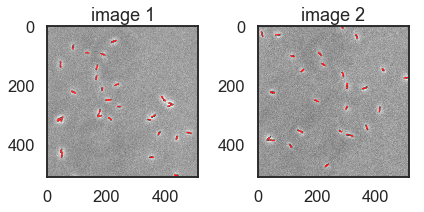

In [16]:
# Make copies of each normalized phase image. 
phase_copy1 = np.copy(phase_norm1)
phase_copy2 = np.copy(phase_norm2)

# Using the segmentation masks, color the pixels with a value of 1.0 wherever a
# segmented object exists. 
phase_copy1[thresh_im1] = 1.0
phase_copy2[thresh_im2] = 1.0

# Make an RGB image of the segmentation by generating a three dimensional array.
rgb_image1 = np.dstack((phase_copy1, phase_norm1, phase_norm1))
rgb_image2 = np.dstack((phase_copy2, phase_norm2, phase_norm2))

with sns.axes_style('white'):
    # Show both images again using a subplot.
    # Since these are RGB, we won't need to use a colormap.
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(rgb_image1)
    ax[0].set_title('image 1')
    ax[1].imshow(rgb_image2)
    ax[1].set_title('image 2')
    
    plt.tight_layout()

It looks like we've done a really great job! Ultimately we want to take a look at the *single cell intensities*, but it looks like we've segmented clusters of cells as a single object. Furthermore, we've only managed to identify where bacteria are, but we have no way of identifying one object from another. In the next step of our pipeline, we'll individually label each cell and figure out how to separate what's worth keeping and what should be tossed. 

## Filtering - Which cells do we keep? 

While we've done a good job at segmenting what pixels are part of bacteria, we haven't separated them into single cells. We can identify "islands" of bacterial pixels (marked as 1.0's) in a sea of background pixels (marked as 0's) using the `skimage.measure.label` function. This function will return an image where each isolated object is marked with a single value (the first bacterium will be all `1.0`'s, the second `2.0`'s, etc.) as well as the total number of objects we've segmented. By looking at our segmented image, we would expect around 25 objects.  

In [18]:
# Label each individual cell. 
im_lab, num_obj = skimage.measure.label(thresh_im1, return_num=True)
                                   
# Print out how many we identified. By eye, we expect around 25.
print("Number of objects found: %s" %num_obj)

Number of objects found: 25


That seems right on the money! Now, let's plot the labeled image. This time we'll use a rainbow colormap rather than grays. 

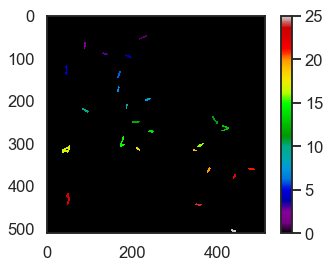

In [20]:
# Show our labeled objects using a a different color map than gray. 
rainbow = plt.cm.nipy_spectral

with sns.axes_style('white'):
    plt.imshow(im_lab, cmap=rainbow)
    plt.colorbar()

Now that each object is individually labeled, we can use some clever indexing to look at each object.

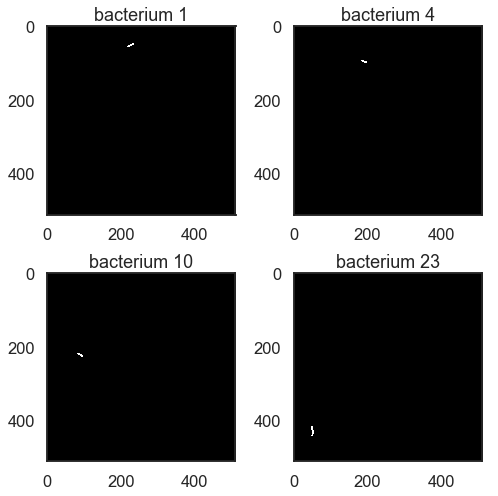

In [24]:
with sns.axes_style('white'):
    # Generate a subplot to look at four different bacteria. 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

    # Isolate bacteria 1, 4, 10, and 23.
    bac_1 = im_lab == 1
    bac_4 = im_lab == 4
    bac_10 = im_lab == 10
    bac_22 = im_lab == 23 


    # Show each bacterium
    ax[0, 0].imshow(bac_1, cmap=gray)
    ax[0, 1].imshow(bac_4, cmap=gray)
    ax[1, 0].imshow(bac_10, cmap=gray)
    ax[1, 1].imshow(bac_22, cmap=gray)

    # Add the titles. 
    ax[0, 0].set_title('bacterium 1')
    ax[0, 1].set_title('bacterium 4')
    ax[1, 0].set_title('bacterium 10')
    ax[1, 1].set_title('bacterium 23')

    # Adjust the spacing so the labels don't overlap.
    plt.tight_layout()

We can see that there are some issues where clusters of cells were segmented as a single object, such as bacterium 23 shown above. However, we can note that these clusters of cells are larger than single cells, meaning that we can filter these labeled objects by their **area**. Since these are boolean images, we can simply sum up an image with a single bacterium selected to get the area.

In [25]:
cell_pix = np.sum(bac_1)
print("The area of our single cell is %s pixels." %cell_pix)

The area of our single cell is 91 pixels.


How big is a typical bacterium? We know that the standard laboratory *E. coli* strain is around 1 - 2µm in length by 1µm in diameter, but how many pixels does that correspond to? To do this conversion, we would need to know how far apart individual pixels are on our camera. While we could figure this out using some image processing and some images of a [stage micrometer](http://www.amscope.com/stage-micrometer-calibration-measure-for-microscopes.html?gclid=CjwKEAjw2qzHBRChloWxgoXDpyASJAB01Io0B7GVHR82blURNBqeBZJNfoHDS_Q0kSR3mrlFCEnkVBoCNV_w_wcB) (essentially a slide with a millimeter sized ruler printed on the glass), I know that these images were taken using a camera with a 160 nm interpixel distance. 

Using this interpixel distance, let's calculate the area of bacterium 1.

In [26]:
# Convert pixels to physical units. 
ip_dist = 0.160  # In units of microns per pixel. 
cell_area = cell_pix * ip_dist**2
print("The area of our single cell is %s square microns." %cell_area)

The area of our single cell is 2.3296 square microns.


This measurement falls very close to what we expect of our "typical" *E. coli* cell. Let's determine the size of all of the *E. coli* cells in this particular image by looping this procedure over each labeled object. 

Text(0, 0.5, 'count')

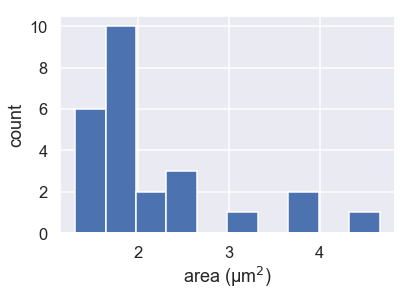

In [27]:
# Make an array where we'll store the cell areas.
areas = np.zeros(num_obj)

# Loop through each object. Remember that we have to start indexing at 1 in
# this case!
for i in range(num_obj):
    # Slice out the cell of interest. 
    cell = (im_lab == i + 1)
    
    # Compute the area and add it to our array
    areas[i] = np.sum(cell) * ip_dist**2

    
# Plot a histogram of our areas. 
plt.hist(areas, bins=10)
plt.xlabel('area (µm$^2$)')
plt.ylabel('count')

We have few segmented objects that are a bit too big, hovering around 4.0 to 5.0 µm$^2$. These are likely the few clumps that we have.

Now that we have our hands on a parameter that will allow us to distinguish single cells, let's generate a new segmentation mask ignoring any object with an area greater than 4 µm$^2$ and anything less than 1µm$^2$. We can do this making a blank image and adding only the labels that meet our criterion to this blank image. Since we will be adding binary objects to this image, the final image will need to be relabeled.

Segmented 24 single cells.


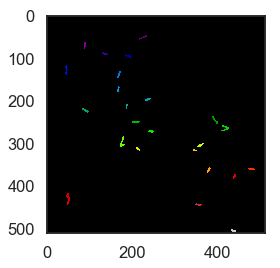

In [28]:
# Make an empty image the same size as our orignal binary image
approved_cells = np.zeros_like(thresh_im1)

# Loop through each object and test its area.
for i in range(num_obj):
    # Get the cell of interest.
    cell = (im_lab == i + 1)
    
    # Compute its area. 
    cell_area = np.sum(cell) * ip_dist**2
    
    # Test if it is within our bounds. 
    if (cell_area > 1.0) & (cell_area < 4.0):
        
        # Add our extraced cell to our blank image.
        approved_cells += cell
       
# Relabel and show the approved_cells mask   
approved_lab, num_obj = skimage.measure.label(approved_cells, return_num=True)

print("Segmented %s single cells." %num_obj)
with sns.axes_style('white'):
    plt.imshow(approved_lab, cmap=rainbow)

That looks pretty good, although we have one clump that is recognized a single object. We can accept this segmentation failure as we have many other single cells. **We will leave it up to  you in to think of other ways to refine this segmentation procedure.** 

We can now generate an RGB overlay of our final segmentation image with our original phase contrast image. We can also add a scale bar of 10 µm so we can have a sense of scale.  

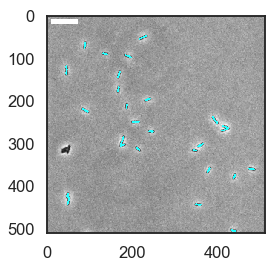

In [29]:
# Make a copy of the normalized phase image. 
phase_copy = np.copy(phase_norm1)

# Add a scale bar to the original image and the copy.
bar_length = int(10 / ip_dist)  # This needs to be an integer since it is in 
                                # units of pixels. 
    
phase_norm1[10:20, 10:10 + bar_length] = 1.0
phase_copy[10:20, 10:10 + bar_length] = 1.0

# Give the segmented pixels a value of 1.0
phase_copy[approved_cells] = 1.0

# Make an RGB image and show it. This time, we'll make them cyan. 
mask_rgb = np.dstack((phase_norm1, phase_copy, phase_copy))

# Show it off!
with sns.axes_style('white'):
    plt.imshow(mask_rgb)

We've finally tuned down our segmentation mask to only include cells we want to measure. Now, let's figure out how to measure their intensity.  

## Measurement - How bright are the bugs?

While the phase contrast image is useful for segmentation, it tells us nothing about the level of gene expression. As was shown in the strain schematic at the beginning of this tutorial, we can measure the expression of a yellow fluorescent protein as a reporter of gene expression. For this experiment, we've also taken a YFP fluorescence image of the same field of cells. Let's load in this image and take a look. 

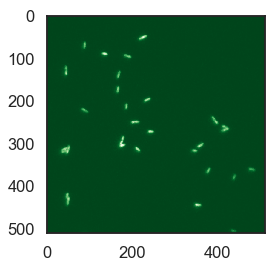

In [31]:
# Load the fluorescence image for this position. 
yfp_im = skimage.io.imread('data/gene_expression/ecoli_yfp_01.tif')

# Show it with a green colormap. 
green = plt.cm.Greens_r
with sns.axes_style('white'):
    plt.imshow(yfp_im, cmap=green)

Using our labeled segmentation mask, we would like to measure the total fluorescence of each individual cell. By multiplying one indexed cell at a time with the fluorescence image, we can extract the pixel intensity values for each individual cell. Let's try this by looking at cell number 6.

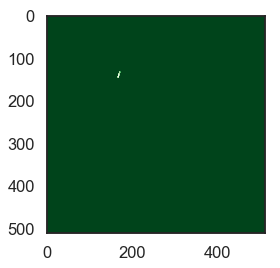

In [32]:
# Look at the intensity image only for cell 6. 
cell_id = 6
cell = (approved_lab == cell_id)

# Multiply the images. 
cell_yfp = cell * yfp_im

# Show the multiplied images.
with sns.axes_style('white'):
    plt.imshow(cell_yfp, cmap=green)

Now that we have this multiplication, we can simply sum the image to get the total intensity of that cell.  

In [33]:
# Get the total cell intensity. 
total_int = np.sum(cell_yfp)
print('The total intensity of cell number 5 is %s counts.' %total_int)

The total intensity of cell number 5 is 166537 counts.


Of course, we care about the population mean intensity, not just a single cell. Let's repeat this procedure over every object in this image and generate a histogram of the intensity values. 

Text(0, 0.5, 'count')

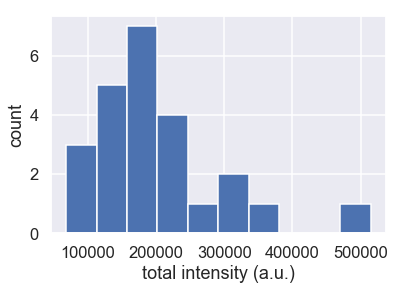

In [34]:
# Set up storage vectors for the cell areas and intensities
tot_ints = np.zeros(num_obj) 
cell_areas = np.zeros(num_obj)

# Loop through each cell. 
for i in range(num_obj):
    # Get the single cell mask. 
    cell = (approved_lab == i + 1)

    # Store the area.
    cell_areas[i] = np.sum(cell) * ip_dist**2
    
    # Multiply it with the fluorescence image. 
    int_im = cell * yfp_im

    # Store the total intensity
    tot_ints[i] = np.sum(int_im)
    
# Plot the histogram. 
plt.hist(tot_ints, bins=10)
plt.xlabel('total intensity (a.u.)')
plt.ylabel('count')

With a vector of intensity values, we can compute the mean expression level of this field of view. 

In [38]:
# Compute the mean fluorescence level.
mean_int = np.mean(tot_ints)
print('The mean single-cell intensity for this image is {:.0f} counts.'.format(mean_int))

The mean single-cell intensity for this image is 200514 counts.


## Some shortcuts... 

While we have showed you how to extract the single-cell area and the total intensity in a simple way, this can also be done using the `skimage.measure` submodule. There is a function called `regionprops` which allows one to make [a variety of different measurements](http://scikit-image.org/docs/dev/api/skimage.measure.html#regionprops) from individually labeled objects. For example, we can measure the single-cell mean intensity and area as follows: 

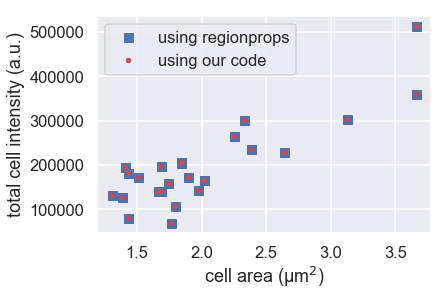

In [39]:
# Compute the region properties. 
props = skimage.measure.regionprops(approved_lab, intensity_image=yfp_im)

# Set up the storage vectors. 
regionprops_areas = np.zeros(num_obj)
regionprops_intensity = np.zeros(num_obj)

# Loop through each object and extract the properties. 
for i in range(len(props)):
    # Extract the areas. 
    regionprops_areas[i] = props[i].area * ip_dist**2
    
    # Extract the mean intensity.
    regionprops_intensity[i] = props[i].mean_intensity * props[i].area 
   

# Plot the intensity versus area to show that we get the same value.
plt.plot(regionprops_areas, regionprops_intensity, 's', label='using regionprops')
plt.plot(cell_areas, tot_ints, 'r.', label='using our code')
plt.xlabel('cell area (µm$^2$)')
plt.ylabel('total cell intensity (a.u.)') 
plt.legend()

While both of these methods produce the same result, it is often easier to use the `regionprops` function to calculate other properties rather than writing  the code yourself.

## In conclusion... 

In this tutorial, we have learned what an image actually is, some basic principles of image processing, and how to extract quantitative data from it. On the whole, image processing and object recognition is a very fertile field of computer science and has far-reaching applications in astronomy, AI development, biology, and many more. 

In this week's homework, you will get to flex your image processing muscles to experimentally measure the fold-change in gene expression. As is described in the homework text, you'll also have to compute the level of gene expression for 5 different repressor copy number mutants as well as two control samples. For each sample, you will have many images you will have to process to compute the mean single-cell expression value for that strain. That means that you will need to write some functions to do this and you should **not** try to copy and paste code over and over again to process all of these samples. 